In [70]:
import pandas as pd
import numpy as np
 
# To remove the scientific notation from numpy arrays
np.set_printoptions(suppress=True)
 
# Fetching the data
StockData=pd.read_csv('TSLA.csv')


<AxesSubplot:xlabel='TradeDate'>

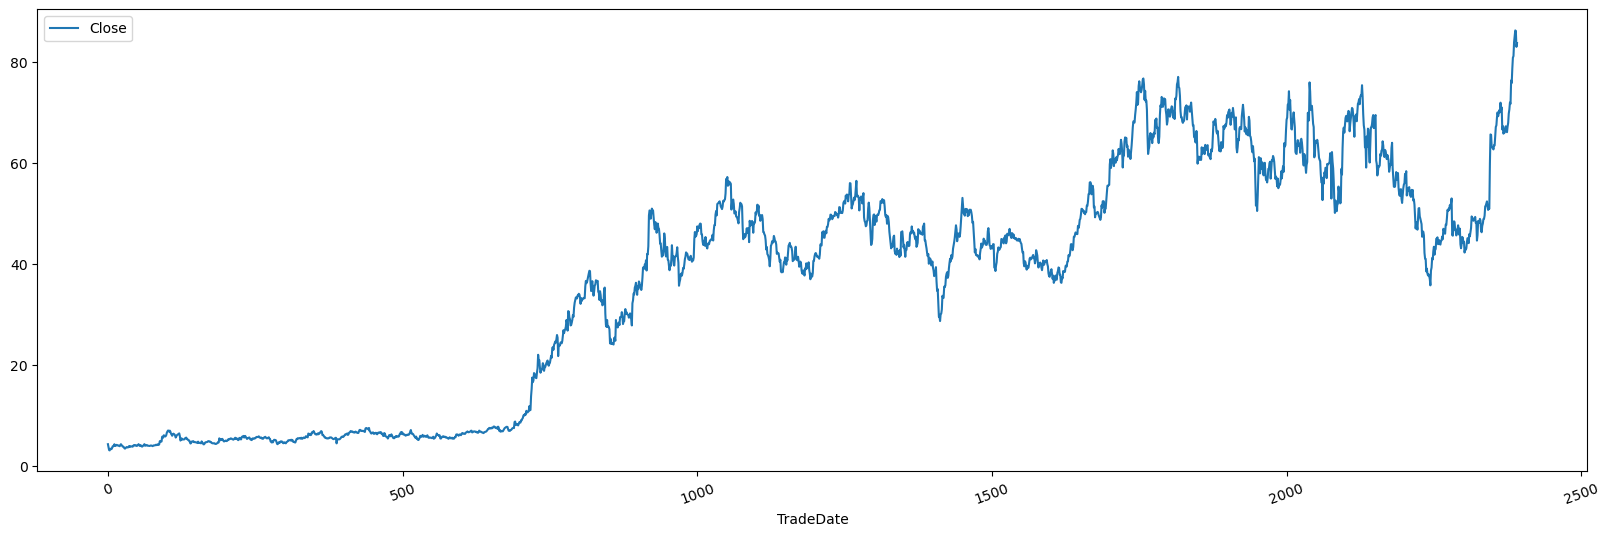

In [71]:
StockData['TradeDate']=StockData.index
 
# Plotting the stock prices
%matplotlib inline
StockData.plot(x='TradeDate', y='Close', kind='line', figsize=(20,6), rot=20)

In [72]:
FullData=StockData[['Close']].values
print(FullData[0:5])
 
# Feature Scaling for fast training of neural networks
from sklearn.preprocessing import StandardScaler, MinMaxScaler
 
# Choosing between Standardization or normalization
#sc = StandardScaler()
sc=MinMaxScaler()
 
DataScaler = sc.fit(FullData)
X=DataScaler.transform(FullData)
#X=FullData
 
print('### After Normalization ###')
X[0:5]

[[4.392]
 [3.84 ]
 [3.222]
 [3.16 ]
 [3.492]]
### After Normalization ###


array([[0.01483837],
       [0.00819001],
       [0.00074674],
       [0.        ],
       [0.00399865]])

In [74]:
X=X.reshape(X.shape[0],)

In [93]:
# split into samples
X_samples = list()
y_samples = list()
 
NumerOfRows = len(X)
TimeSteps=100  # next few day's Price Prediction is based on last how many past day's prices
FutureTimeSteps=10 # How many days in future you want to predict the prices
 
# Iterate thru the values to create combinations
for i in range(TimeSteps , NumerOfRows-FutureTimeSteps , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i:i+FutureTimeSteps]
    X_samples.append(x_sample)
    y_samples.append(y_sample)

# Reshape the Input as a 3D (samples, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)

 
# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=np.array(y_samples)


In [94]:
TestingRecords=10
 
# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]
 
#############################################
# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)
 
print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)


#### Training Data shape ####
(2272, 100, 1)
(2272, 10)

#### Testing Data shape ####
(10, 100, 1)
(10, 10)


In [95]:
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

Number of TimeSteps: 100
Number of Features: 1


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# Initialising the RNN
regressor = Sequential()
 
# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
 
# Adding the Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
# Adding the Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))
 
 
# Adding the output layer
# Notice the number of neurons in the dense layer is now the number of future time steps 
# Based on the number of future days we want to predict
regressor.add(Dense(units = FutureTimeSteps))
 
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
 
###################################################################
 
import time
# Measuring the time taken by the model to train
StartTime=time.time()
 
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)
 
EndTime=time.time()

Epoch 1/100
455/455 [==============================] - 75s 158ms/step - loss: 0.0516
Epoch 2/100
455/455 [==============================] - 69s 152ms/step - loss: 0.0048
Epoch 3/100
455/455 [==============================] - 68s 150ms/step - loss: 0.0034
Epoch 4/100
455/455 [==============================] - 68s 149ms/step - loss: 0.0031
Epoch 5/100
455/455 [==============================] - 66s 146ms/step - loss: 0.0030
Epoch 6/100
455/455 [==============================] - 67s 146ms/step - loss: 0.0027
Epoch 7/100
455/455 [==============================] - 66s 146ms/step - loss: 0.0026
Epoch 8/100
455/455 [==============================] - 66s 144ms/step - loss: 0.0025
Epoch 9/100
455/455 [==============================] - 68s 149ms/step - loss: 0.0024
Epoch 10/100
455/455 [==============================] - 69s 152ms/step - loss: 0.0023
Epoch 11/100
455/455 [==============================] - 68s 149ms/step - loss: 0.0022
Epoch 12/100
455/455 [==============================] - 76s 166

In [ ]:
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
print('#### Predicted Prices ####')
print(predicted_Price)
 
# Getting the original price values for testing data
orig=y_test
orig=DataScaler.inverse_transform(y_test)


In [ ]:
for i in range(len(orig)):
    Prediction=predicted_Price[i]
    Original=orig[i]
    
    # Visualising the results
    plt.plot(Prediction, color = 'blue', label = 'Predicted Volume')
    plt.plot(Original, color = 'lightblue', label = 'Original Volume')
 
    plt.title('### Accuracy of the predictions:'+ str(100 - (100*(abs(Original-Prediction)/Original)).mean().round(2))+'% ###')
    plt.xlabel('Trading Date')
    
    startDateIndex=(FutureTimeSteps*TestingRecords)-FutureTimeSteps*(i+1)
    endDateIndex=(FutureTimeSteps*TestingRecords)-FutureTimeSteps*(i+1) + FutureTimeSteps
    TotalRows=StockData.shape[0]
 
    plt.xticks(range(FutureTimeSteps), StockData.iloc[TotalRows-endDateIndex : TotalRows-(startDateIndex) , :]['TradeDate'])
    plt.ylabel('Stock Price')
 
    plt.legend()
    fig=plt.gcf()
    fig.set_figwidth(20)
    fig.set_figheight(3)
    plt.show()

In [ ]:
last_15_days = np.array(FullData[-20:])
last_10_days = np.array(FullData[-20:-10])

In [ ]:
# Reshaping the data to (-1,1 )because its a single entry
last_10_days=last_10_days.reshape(-1, 1)
 
# Scaling the data on the same level on which model was trained
X_test=DataScaler.transform(last_10_days)
 
NumberofSamples=1
TimeSteps=X_test.shape[0]
NumberofFeatures=X_test.shape[1]
# Reshaping the data as 3D input
X_test=X_test.reshape(NumberofSamples,TimeSteps,NumberofFeatures)
 
# Generating the predictions for next 5 days
Next5DaysPrice = regressor.predict(X_test)
 
# Generating the prices in original scale
Next5DaysPrice = DataScaler.inverse_transform(Next5DaysPrice)
Next5DaysPrice

In [ ]:
x = np.arange(0, 20 ,1)
y = np.arange(0, 10 ,1)
z = np.arange(10, 20 ,1)

In [ ]:
plt.plot(x, last_15_days, color='r')
plt.plot(y, last_10_days, color='b')
Next5DaysPrice = Next5DaysPrice.reshape(10, 1)
plt.plot(z, Next5DaysPrice, color='g')
plt.show()

(1, 5)